<font size="+4" color=Green><b> <center><i>Image Classifier Convolutional Neural Network with Transfer Learning</i></center></b></font>

In [9]:
#importing libraries
from fastai import *
from fastai.vision import *
from fastai.metrics import error_rate
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import torch
import torchvision as tv
import splitfolders


print("Done")

Done


In [10]:
# Check torch is using GPU
print(torch.cuda.is_available())
# Check GPU name
print(torch.cuda.get_device_name(0))



True
NVIDIA GeForce GTX 1080


In [11]:
x = '/traindata'
x = os.getcwd() + x
print(x)
# N elements in list are the number of classes/folders for each class
path = Path(x)
path.ls()

D:\Projects\VUW\2022\421\capstone\exploring/traindata


[WindowsPath('D:/Projects/VUW/2022/421/capstone/exploring/traindata/cherry'),
 WindowsPath('D:/Projects/VUW/2022/421/capstone/exploring/traindata/strawberry'),
 WindowsPath('D:/Projects/VUW/2022/421/capstone/exploring/traindata/tomato')]

In [12]:
# Split off testing data
#@TODO just use validation their testing system is pretty bad.
splitfolders.ratio('traindata/', output="split", seed=42, ratio=(.8, 0.1, 0.1))


Copying files: 4500 files [00:10, 432.13 files/s]


In [13]:

split_dir = os.getcwd() + "/split/"
print(os.listdir(split_dir))

['test', 'train', 'val', 'valid']


In [14]:
# # Rename val dir to valid
# # Path
# path = Path('split')
# # Rename val dir to valid for fastai (match imagenet)
# os.rename(path / 'val', path / 'valid')


In [15]:
# Baseline MLP For Comparison
# Create a baseline MLP model
# Switched to standalone program: https://mlp-image-classifier.readthedocs.io/en/latest/installation.html


In [16]:
# Loading Data.
# https://alexiej.github.io/deepnn/#imagedatabunch
# - Set Validation percentage (20%) - DONE IN SPLIT NOW
# - Set training data path
# - Set image size (300)
# - @TODO ADAPTATION TO TEST:  Resize in some way to 224x224 to match imagenet model training
# - Set transforms for augmenting dataset (optional)
#   @TODO - ADAPTATION TO TEST: # Guide:  https://fastai1.fast.ai/vision.transform.html
#   https://www.kaggle.com/code/init27/introduction-to-image-augmentation-using-fastai/notebook
# - Set test data path (optional)
# - Set number of workers
# - Normalize data

transformsA = get_transforms(
    do_flip=True,
    flip_vert=True,
    max_rotate=10.0,
    max_zoom=1.1,
    max_lighting=0.2,
    max_warp=0.2,
    p_affine=0.75,
    p_lighting=0.75)

transformsB = get_transforms()

np.random.seed(42)
# noinspection PyNoneFunctionAssignment
data = ImageDataBunch.from_folder(split_dir,
                                  train="train",
                                  valid="val",
                                  test="test",
                                  ds_tfms=transformsA,
                                  size=224,  #@TODO Try on 300 as well
                                  num_workers=6).normalize(imagenet_stats)

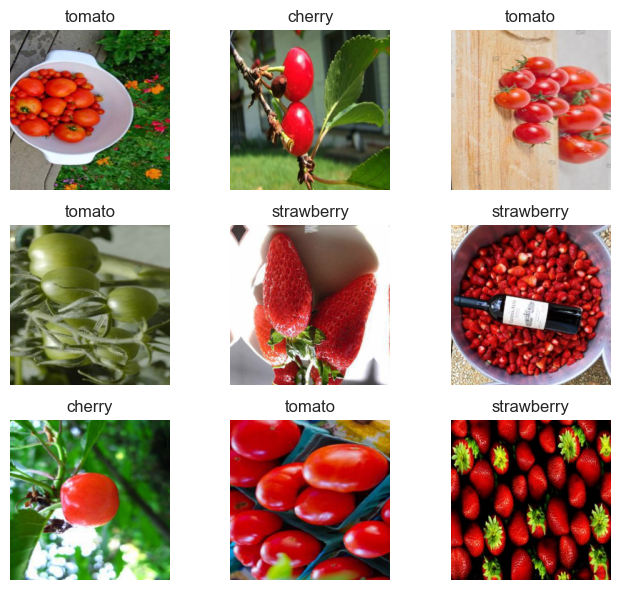

In [17]:
# Preview Data
data.show_batch(rows=3, figsize=(7, 6), recompute_scale_factor=True)

In [18]:
data

ImageDataBunch;

Train: LabelList (3600 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cherry,cherry,cherry,cherry,cherry
Path: D:\Projects\VUW\2022\421\capstone\exploring\split;

Valid: LabelList (450 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cherry,cherry,cherry,cherry,cherry
Path: D:\Projects\VUW\2022\421\capstone\exploring\split;

Test: LabelList (450 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: D:\Projects\VUW\2022\421\capstone\exploring\split

In [19]:
print(data.classes)
len(data.classes)
data.c

['cherry', 'strawberry', 'tomato']


3

In [20]:
# layers.//

#         self.groups = groups
#         self.base_width = width_per_group
#         self.conv1 = nn.Conv2d(3, self.inplanes, kernel_size=7, stride=2, padding=3,bias=False)
#         self.bn1 = norm_layer(self.inplanes)
#         self.relu = nn.ReLU(inplace=True)
#         self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
#         self.layer1 = self._make_layer(block, 64, layers[0])
#         self.layer2 = self._make_layer(block, 128, layers[1], stride=2,
#                                        dilate=replace_stride_with_dilation[0])
#         self.layer3 = self._make_layer(block, 256, layers[2], stride=2,
#                                        dilate=replace_stride_with_dilation[1])
#         self.layer4 = self._make_layer(block, 512, layers[3], stride=2,
#                                        dilate=replace_stride_with_dilation[2])
#         self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
#         self.fc = nn.Linear(512 * block.expansion, num_classes)
#         # Zero-initialize the last BN in each residual branch,
#         # improves the model by 0.2~0.3% according to https://arxiv.org/abs/1706.02677


In [21]:
# Create Model using ResNet18 Convolutional Neural Net.
# - Learn weights of last layer only (transfer learning)
# - Lets us use the existing model instead of requiring a huge dataset to train our own accurate model.
# - We only have a few thousand - good models use millions - ResNet18 used about a million images from ImageNet
# RESNET https://towardsdatascience.com/an-overview-of-resnet-and-its-variants-5281e2f56035?gi=44dbd996042e
learn = cnn_learner(data,
                    models.resnet18,
                    metrics=[accuracy],
                    model_dir=Path('../export/working'),
                    path=Path("."))

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


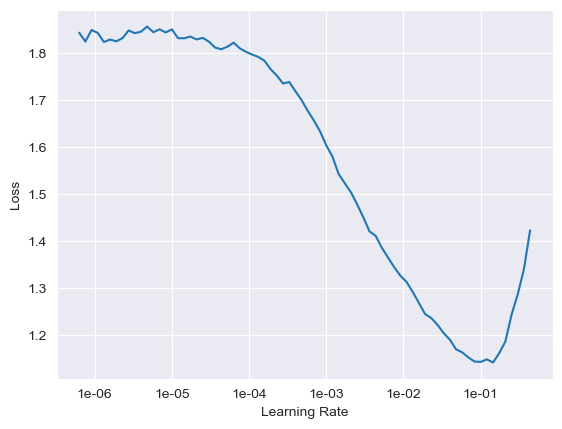

In [22]:
# Find Learning Rate
learn.lr_find()
learn.recorder.plot(suggestions=True)

In [23]:
# Set learning rate dynamically from plot
lr1 = 1e-3
lr2 = 1e-1
learn.fit_one_cycle(40, slice(lr1, lr2))

In [24]:
# Tune hyper params
learn.unfreeze()
learn.fit_one_cycle(20, slice(1e-4, 1e-3))


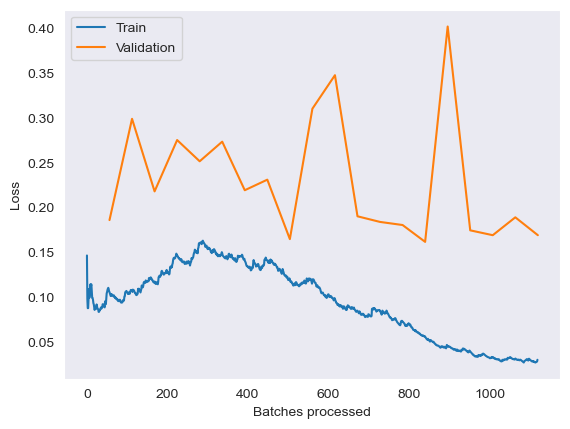

In [25]:
# Plot losses
learn.recorder.plot_losses()

In [26]:
# Fine tune
#learn.fine_tune(2)

Accuracy:  tensor(0.9533)


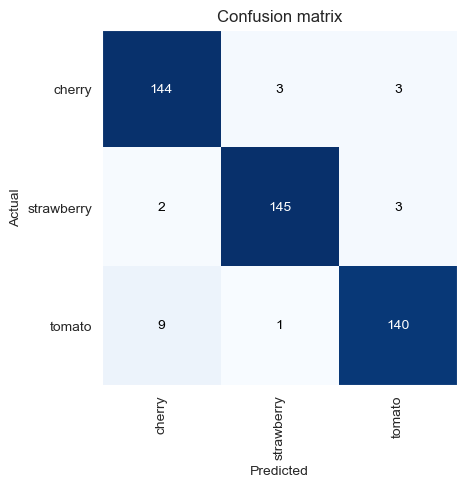

In [27]:
# Confusion matrix shows number of incorrect predictions and what was predicted
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()
# Print accuracy
print("Accuracy: ", accuracy(*learn.get_preds()))

D:\Projects\VUW\2022\py376venv\lib\site-packages\torch\nn\functional.py:2854: UserWarning: The default behavior for interpolate/upsample with float scale_factor will change in 1.6.0 to align with other frameworks/libraries, and use scale_factor directly, instead of relying on the computed output size. If you wish to keep the old behavior, please set recompute_scale_factor=True. See the documentation of nn.Upsample for details. 
  warnings.warn("The default behavior for interpolate/upsample with float scale_factor will change "


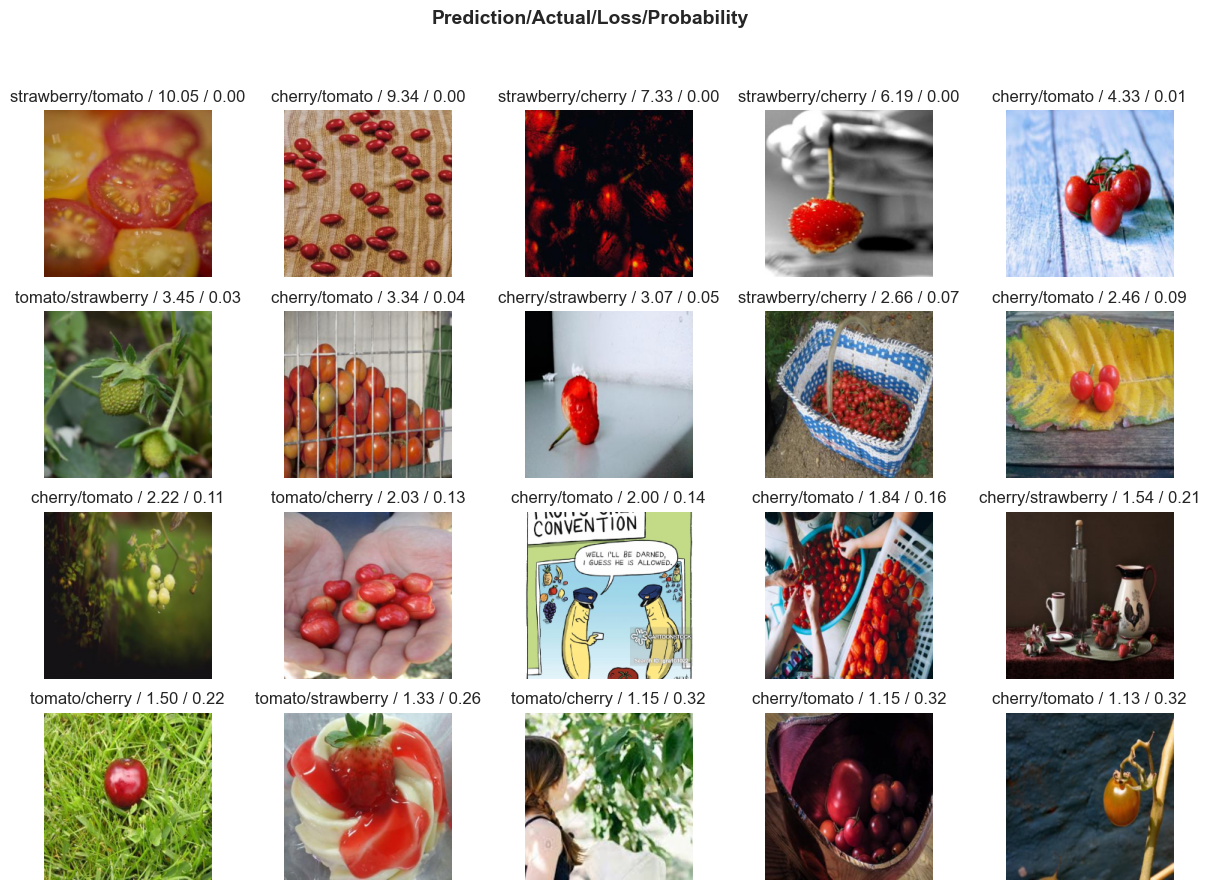

In [44]:
interp.plot_top_losses(20, figsize=(15, 10))

In [29]:
# Run individual prediction
loc = '/traindata/cherry/cherry_0003.jpg'
loc = os.getcwd() + loc

img = open_image(loc)
print(learn.predict(img)[0])

cherry


In [30]:
print(learn.validate()[1])


tensor(0.9533)


In [31]:
# Test with test data
data.test_ds

LabelList (450 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: EmptyLabelList
,,,,
Path: D:\Projects\VUW\2022\421\capstone\exploring\split

In [32]:
# # Predict on test data
# # https://forums.fast.ai/t/get-preds-is-confusing/74791/3
# preds, _ = learn.get_preds(ds_type=DatasetType.Test)
# @TODO WITH LABELS


In [33]:
# their labels suck
# x = '/split/test'
# x = os.getcwd() + x
# test_imgs = ("").ls()
# test_imgs.sort(key=lambda x: x.stem)
# data.add_test(test_imgs)
# learn.data = data
# preds = learn.get_preds(ds_type=DatasetType.Test)


In [34]:
#


In [35]:
# Export for use outside
learn.export()

# Save for resumption
working_dir = os.getcwd() + "/export/working"
learn.model_dir = working_dir
saved_location = learn.save("stage-1", return_path=True)
print("Saved to ", saved_location)

Saved to  D:\Projects\VUW\2022\421\capstone\exploring\export\working\stage-1.pth


In [36]:
# %%capture cap_out --no-stderr
# interp.print_classification_report()

AttributeError: 'ClassificationInterpretation' object has no attribute 'print_classification_report'

In [37]:
# classification_report = cap_out.stdout
#
# from itertools import groupby
# class_report = pd.DataFrame([])
# def split_text(s):
#     for k, g in groupby(s, str.isnumeric):
#         yield ''.join(g)
#
# report = []
# for item in classification_report.split('\n'):
#   report.append(split_text(item))
#
# report = pd.DataFrame(report).copy()
# class_report = pd.DataFrame([])
# class_report['Class'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,0]
# class_report['Precision'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,3].apply(lambda x:int(x)/100)
# class_report['Recall'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,7].apply(lambda x:int(x)/100)
# class_report['F1 Score'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,11].apply(lambda x:int(x)/100)
# class_report['Support'] = pd.DataFrame(report).iloc[2:learn.dl.c+2,13]

AttributeError: 'function' object has no attribute 'c'